In [2]:
import handle_chimeras as hc
import helper
import numpy as np
import seaborn as sns
from scipy import ndimage
import skimage as sk

In [3]:
chimfile = '/home/ru27wav/Downloads/SC35M_4xHA_repli01_1021_trimmed_bwa.chim'
trnsfile = '/home/ru27wav/Downloads/SC35M_4xHA_repli01_1021_trimmed.trns.txt'
genome = '/home/ru27wav/Downloads/SC35M_4xHA.fasta'

In [4]:
genome_dict = helper.parse_genome(genome)
combination_array_trns = helper.make_combination_array(genome_dict)
combination_array_chim = helper.make_combination_array(genome_dict)

In [5]:
hc.bwaChimera2heatmap(chimfile, combination_array_chim)
hc.segemehlTrans2heatmap(trnsfile, combination_array_trns)

In [6]:
HA_M_chim = combination_array_chim[('SC35M_HA','SC35M_M')]
print(HA_M_chim)
HA_M_trns = combination_array_trns[('SC35M_HA','SC35M_M')]
print(HA_M_trns)

[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


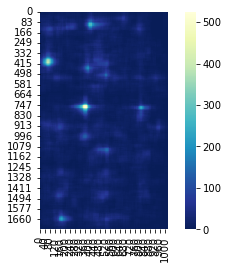

In [7]:
chim_heatmap = sns.heatmap(HA_M_chim, square=True, cmap="YlGnBu_r")

722


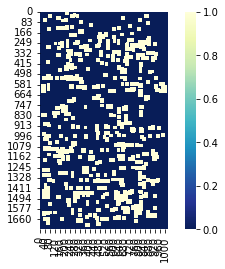

In [14]:
def detect_peaks(interaction_array):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define a 30 by 30 neighborhood
    neighborhood = np.ones((30,30))

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    # local_max = np.isclose(ndimage.maximum_filter(interaction_array, footprint=neighborhood), interaction_array)
    local_max = ndimage.maximum_filter(interaction_array, footprint=neighborhood)==interaction_array

    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must constraint the peaks to the foreground.

    #we create the mask of the foreground
    foreground = (interaction_array > 10)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max & foreground

    labeled_array, num_features = ndimage.label(detected_peaks)

    detected_peaks = ndimage.maximum_filter(detected_peaks , footprint=neighborhood)

    return detected_peaks, labeled_array, num_features

chim_peaks = detect_peaks(HA_M_chim)
print(chim_peaks[2])
chim_peaks_heatmap = sns.heatmap(chim_peaks[0], square=True, cmap="YlGnBu_r")


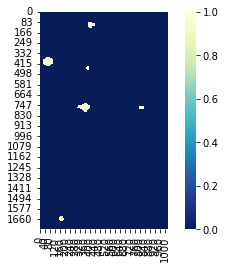

In [9]:
def detect_regions_tophat_scikit_image(interaction_array):
    """
    Takes an array and detect regions using the tophat algorithm.
    Returns an array of labeled regions)
    """
    # defines a 40 by 40 square to use as a template
    footprint = ndimage.generate_binary_structure(rank=2, connectivity=2)

    # arbitrary filter that removes low-coverage regions
    filtered_array = np.where(interaction_array < 150, 0, interaction_array)

    # apply the tophat filter, removing squares smaller than the footprint
    filtered_array = filtered_array - sk.morphology.white_tophat(interaction_array, footprint)
    filtered_array = np.where(interaction_array < 150, 0, 1)

    # label the regions
    labeled_array, num_features = ndimage.label(filtered_array)
    return filtered_array

chim_regions = detect_regions_tophat_scikit_image(HA_M_chim)
chim_regions_heatmap = sns.heatmap(chim_regions, square=True, cmap="YlGnBu_r")

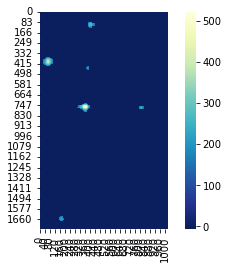

In [10]:
def detect_regions_tophat_scipy(interaction_array):
    """
    Takes an array and detect regions using the tophat algorithm.
    Returns an array of labeled regions)
    """
    # defines a square to use as a template
    square = ndimage.generate_binary_structure(rank=2, connectivity=2)

    # arbitrary filter that removes low-coverage regions
    filtered_array = np.where(interaction_array < 150, 0, interaction_array)

    # apply the tophat filter, removing squares smaller than the structure
    filtered_array = filtered_array - ndimage.white_tophat(interaction_array, structure=square)

    # label the regions
    labeled_array, num_features = ndimage.label(filtered_array)
    return filtered_array

chim_regions = detect_regions_tophat_scipy(HA_M_chim)
chim_regions_heatmap = sns.heatmap(chim_regions, square=True, cmap="YlGnBu_r")

In [ ]:
def import_arrays(dir_name):
    """
    Import all arrays in a directory

    input:
        dir_name: directory name

    output:
        array_list: dictionarry of arrays
    """
    arrays = {}

    for path, subdirs, files in os.walk(dir_name):
        for name in files:
            if name[-3:-1] == 'npy':
                print(os.path.join(path, name))
                arrays[name] = np.load(os.path.join(path, name))
    return arrays

arrays = import_arrays('/home/ru27wav/Projects/gl_iav-splash_freiburg/results/schwemmle_group/03-heatmaps')